In [1]:
cd "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/minian"

C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian


In [2]:
import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval
import seaborn as sns
from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [130]:
MiceList=['RedLinesOK']
MiceList=['ThreeColDotsOK']

DrugExperiment=[1]

In [131]:
# # Associate Ca2+ signal with spindles for each session & subsessions using crossregistration

#######################################################################################
                            # Define Experiment type #
#######################################################################################

#DrugExperiment=0 #if Baseline Experiment =1#if CGP Experiment
DrugExperimentList=DrugExperiment

saveexcel=0

Method=0 # 1=AB 0=AH
AnalysisID='_ToDelete' 

suffix='_AB' if Method else '_AH'

CTX=['S1', 'PFC', 'S1PFC']

Coupling=['', 'UnCoupled', 'Coupled']

#######################################################################################
                                # Load packages #
#######################################################################################

import os
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
from scipy.signal import find_peaks
from scipy.stats import zscore
import pickle
import os
from scipy.interpolate import griddata
import logging
import sys 
import shutil
from bisect import bisect_left
from ast import literal_eval
from scipy import interpolate

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

minian_path = os.path.join(os.path.abspath('.'),'minian')
print("The folder used for minian procedures is : {}".format(minian_path))
sys.path.append(minian_path)


from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

#######################################################################################
                                # Define functions #
#######################################################################################

def is_between(myList, starttime, endtime):
    IsTrue=False
    for ind in range(len(myList)):
        if starttime <= myList[ind] <= endtime:
            IsTrue=True
    return IsTrue

def is_overlapping(starttime, endtime, starttimeList, endtimeList):
    IsTrue='False'
    for ind in starttimeList.index: #range(len(starttimeList)):
        if starttime<=starttimeList[ind] and starttimeList[ind]<=endtime: # event n°2 begins after the start n°1               
            if (endtime-starttimeList[ind])>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break                
        elif starttime<=endtimeList[ind] and endtimeList[ind]<=endtime: # event n°2 ends before the end n°1 
            if (endtimeList[ind]-starttime)>=int(0.5*(endtime-starttime)): # overlapp > to 50% of the duration of the event n°1
                IsTrue='True'
                break
    return IsTrue, ind

def find_session_folders(root_path):
    sessions = []
    sessions_path=[]
    # Iterate through items in the root_path
    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)
        if os.path.isdir(item_path):
            # Check if the directory name contains "session"
            if "session" in item:
                sessions.append(item)
                sessions_path.append(item_path)
            else:
                # Check the subdirectories of the current directory
                for sub_item in os.listdir(item_path):
                    sub_item_path = os.path.join(item_path, sub_item)
                    if os.path.isdir(sub_item_path) and "session" in sub_item:
                        sessions.append(sub_item)
                        sessions_path.append(sub_item_path)
                        
    return sessions, sessions_path

#######################################################################################
                # Load sleep score and Ca2+ time series numpy arrays #
#######################################################################################

for DrugExperiment in DrugExperimentList: 

    Drugs=['Baseline', 'CGP'] if DrugExperiment else ['Baseline']

    MiceList=MiceList
    
    for mice in MiceList:

        dpath0 = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/CGP/" if DrugExperiment else "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording_ABmodified/"
        dpath=dpath0 + mice
        print(f"####################################################################################")
        print(f"################################### {mice} ####################################")
        print(f"####################################################################################")
        print(f"Path to the folder : {dpath}")
        folder_base = Path(dpath)

        mfile = open(folder_base / f'mappingsAB_ALL.pkl', 'rb')
        mapping = pickle.load(mfile)
        print('mappingsAB_ALL.pkl opened')

        subsessions = []
        dict_Calcium = {}
        dict_Spike = {}
        dict_SWRprop = {}
        dict_Spindleprop = {}
        dict_Stamps = {}
        dict_StampsMiniscope = {}
        dict_TodropFile = {}
        dict_Path={}

        sessions, sessions_path = find_session_folders(folder_base)
        nb_sessions=len(sessions)

        for sess,session in enumerate(sessions):  
            session_path=Path(sessions_path[sess])
            folder_mini = session_path / f'V4_Miniscope'
            nb_subsessions = sum(1 for p in folder_mini.iterdir() if p.is_dir() and p.name.startswith("session"))
            SWRproperties = session_path / f'OpenEphys/SWRproperties_8sd_AB.xlsx' if Method else session_path / f'OpenEphys/SWRproperties.csv'
            Spindleproperties = session_path / f'OpenEphys/Spindlesproperties_S1&PFC_7sd_AB.xlsx' if Method else session_path / f'OpenEphys/Spindleproperties_S1&PFC.csv'
            StampsFile = session_path / f'SynchroFile.xlsx'
            StampsMiniscopeFile = folder_mini / f'timeStamps.csv'
            if nb_subsessions!=0:
                for x in range(1, nb_subsessions+1):            
                    subsession= session + str(x)
                    subsessions.append(subsession)    
                    minian_ds = open_minian(folder_mini / subsession / f'minian')      # OR minianAB
                    SWRlist= pd.read_excel(SWRproperties) if Method else pd.read_csv(SWRproperties)
                    SWRlist['toKeep'] = SWRlist['toKeep'].astype(str)  if DrugExperiment else 'True'
                    dict_SWRprop[subsession]  =SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]
                    Spdllist = pd.read_excel(Spindleproperties) if Method else pd.read_csv(Spindleproperties)
                    Spdllist['toKeep'] = Spdllist['toKeep'].astype(str)
                    dict_Spindleprop[subsession]  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]
                    dict_Path[subsession] = session_path
                    dict_Calcium[subsession] = minian_ds['C'] # calcium traces 
                    dict_Spike[subsession] = minian_ds['S'] # estimated spikes
                    dict_Stamps[subsession]  = pd.read_excel(StampsFile)
                    dict_StampsMiniscope[subsession]  = pd.read_csv(StampsMiniscopeFile)
                    try:
                        TodropFile = folder_mini / subsession / f'minian/TodropFileAB.json'
                        with open(TodropFile, 'r') as f:
                            unit_to_drop = json.load(f)
                            dict_TodropFile[subsession]  = unit_to_drop
                    except:
                        TodropFile = folder_mini / subsession / f'minian/TodropFile.json'
                        with open(TodropFile, 'r') as f:
                            unit_to_drop = json.load(f)
                            dict_TodropFile[subsession]  = unit_to_drop
            else:
                minian_ds = open_minian(folder_mini / f'minian')            # OR minianAB
                dict_Path[session] = session_path
                dict_Calcium[session] = minian_ds['C'] # calcium traces 
                dict_Spike[session] = minian_ds['S'] # estimated spikes
                SWRlist= pd.read_excel(SWRproperties) if Method else pd.read_csv(SWRproperties)
                SWRlist['toKeep'] = SWRlist['toKeep'].astype(str) if DrugExperiment else 'True'
                dict_SWRprop[session]  =SWRlist[SWRlist['toKeep'].isin(['VRAI', 'True'])]
                Spdllist = pd.read_excel(Spindleproperties) if Method else pd.read_csv(Spindleproperties)
                Spdllist['toKeep'] = Spdllist['toKeep'].astype(str) 
                dict_Spindleprop[session]  = Spdllist[Spdllist['toKeep'].isin(['VRAI', 'True'])]
                dict_Stamps[session]  = pd.read_excel(StampsFile)
                dict_StampsMiniscope[session]  = pd.read_csv(StampsMiniscopeFile)
                try:
                    TodropFile = folder_mini / f'minian/TodropFileAB.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)
                        dict_TodropFile[session]  = unit_to_drop
                except:
                    TodropFile = folder_mini / f'minian/TodropFile.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)
                        dict_TodropFile[session]  = unit_to_drop

        #######################################################################################
                                # Cross registration results #
        #######################################################################################

        B = mapping['session']
        if mice == 'Purple' and DrugExperiment==0:
            index = B.columns
            B.columns = index.str.replace('part', 'session2')

        #######################################################################################
        # Distribute Ca2+ intensity & spikes to oscillations for each sessions/subsessions #
        #######################################################################################

        data = {}        
        before = 500 # Max distance in ms between a SWR and a spindle to be considered as Precoupled
        after = 1000 # Max distance in ms between a spindle and a SWR to be considered as Postcoupled
        durationSpdl = 1 # number of sec before and after the Spdl onset taken into acount
        durationSWR = .5 # number of sec before and after the SWR onset taken into acount
        counter=0
        counter2=0

        norm_freq=20 # final miniscope frequency used for all recordings

        Spindles_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','Drug', 'SpdlStatut','SpdlStartLocation', 'GlobalSpindle', 'SpdlNumber','SpdlDuration','SWR_inside_Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityDuring','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumDuring','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityDuring','SpikeActivityAfter'])
        SWR_GlobalResults= pd.DataFrame(data, columns=['Mice', 'Session','Session_Time','Unique_Unit','UnitNumber','UnitValue','Drug','SWRStatut','SWRNumber','SWRDuration','SWR_inside_Spdl','CalciumActivityPreference', 'CalciumActivityBefore','CalciumActivityDuring','CalciumActivityAfter','AUC_calciumBefore','AUC_calciumDuring','AUC_calciumAfter','SpikeActivityPreference','SpikeActivityBefore','SpikeActivityDuring','SpikeActivityAfter'])
            
        for drug in Drugs: 
            for coup in Coupling:
                for ctx in CTX:            
                    locals()[f'dict_All_ActivityCa_{coup}SPDL{ctx}_{drug}']={}
                    locals()[f'dict_All_ActivitySp_{coup}SPDL{ctx}_{drug}']={}
                locals()[f'dict_All_ActivityCa_{coup}SWR_{drug}']={}
                locals()[f'dict_All_ActivitySp_{coup}SWR_{drug}']={}

        previousEndTime=0
        InitialStartTime=0

        for session in list(dict_Stamps.keys()):    
            cCoupled=0
            cUnCoupled=0
            cGlobal=0
            cLocalS1=0
            cLocalPFC=0

            cCoupledSWR=0
            cUnCoupledSWR=0      
            
            drug=os.path.basename(os.path.dirname(dict_Path[session])) if DrugExperiment else 'Baseline'

            # Start time & freq miniscope

            StartTime = list(dict_Stamps[session][0])[0] # in seconds
            StartTimeO = StartTime
            minian_freq=list(dict_Stamps[session][0])[2] # in Hz
            TimeStamps_miniscope=dict_StampsMiniscope[session]
            TimeStamps_miniscope["Time Stamp (ms)"]=TimeStamps_miniscope["Time Stamp (ms)"] + (StartTimeO*1000)

            minian_freq=round(1/np.mean(np.diff(np.array(TimeStamps_miniscope["Time Stamp (ms)"])/1000)))

            freqLFP=1000

            if minian_freq>=20: # should only remove 1 session                

                # Adjust the StartTime if subsessions

                if InitialStartTime==0:
                    InitialStartTime=StartTime    
                    firstframe=0
                    StartTimeMiniscope=0 # start time of miniscope rec of that subsesssions relative to the start of the mniscope recording
                else:
                    if StartTime == InitialStartTime: # just a subsession
                        StartTime = previousEndTime + 1/minian_freq #  +1 frame in seconds
                        StartTimeMiniscope= StartTime-InitialStartTime
                    else:  
                        InitialStartTime=StartTime # this is a new session
                        firstframe=0
                        StartTimeMiniscope=0  

                # Remove bad units from recordings

                C=dict_Calcium[session]
                S=dict_Spike[session] 

                Calcium = pd.DataFrame(C, index=C['unit_id'])
                Spike = pd.DataFrame(S, index=S['unit_id'])

                unit_to_drop=dict_TodropFile[session]    
                for u in unit_to_drop: 
                    Calcium=Calcium.drop(index=u) if u in Calcium.index else Calcium #need to know why
                    Spike=Spike.drop(index=u) if u in Spike.index else Spike


                indexMappList=B[session]
                kept_uniq_unit_List=[]
                for unit in Calcium.index:
                    indexMapp = np.where(indexMappList == unit)[0]
                    kept_uniq_unit_List.append(str(indexMapp))
                    
                nb_unit=len(Calcium)
                
              
                Carray=Calcium.values.T.astype(float)
                Sarray=Spike.values.T.astype(float)



                StartFrame_msec=TimeStamps_miniscope['Time Stamp (ms)'][TimeStamps_miniscope['Frame Number'][firstframe]]
                LastFrame_msec=TimeStamps_miniscope['Time Stamp (ms)'][TimeStamps_miniscope['Frame Number'][firstframe+len(Calcium.T)-1]]
                TS_miniscope_sub=TimeStamps_miniscope['Time Stamp (ms)'].iloc[firstframe:firstframe+len(Calcium.T)]
                rec_dur=len(Calcium.T)

                rec_dur_sec= (LastFrame_msec - StartFrame_msec)/1000               
                
                nb_of_previousframe=firstframe

                firstframe+=rec_dur

                
                # Deal with dropped frames (failure to acquire miniscope images)

                list_droppedframes = literal_eval(dict_Stamps[session][0][3])    

                numbdropfr= 0   
                droppedframes_inrec=[]
                for item in list_droppedframes: 
                    if item < (int(StartTimeMiniscope*minian_freq) + rec_dur) and item > int(StartTimeMiniscope*minian_freq):
                        numbdropfr+=1                        

                EndTime = StartTime + rec_dur_sec # (upd_rec_dur/minian_freq) # in seconds
                previousEndTime=EndTime 

                print(session, ': starts at', round(StartTime,1), 's & ends at', round(EndTime,1), 's (', round(rec_dur_sec,1), 's duration, ', numbdropfr, 'dropped frames, minian frequency =', minian_freq, 'Hz, drug = ', drug, ')...') 

                sentence1= f"... kept values = {kept_uniq_unit_List}"
                print(sentence1) 

                # Zscore traces

                #Carray=zscore(Carray, axis=0)
                #Sarray=zscore(Sarray, axis=0)

                if nb_unit==0:
                    continue  # next iteration

                # Align Oscillations to miniscope start 

                SpipropO=dict_Spindleprop[session]
                SpipropM=SpipropO.copy()
                SWRpropO=dict_SWRprop[session]
                SWRpropM=SWRpropO.copy()

                SpipropM=SpipropM[SpipropM['start time']> StartFrame_msec]
                SpipropTrunc=SpipropM[SpipropM['end time']< LastFrame_msec]
                SWRpropM=SWRpropM[SWRpropM['start time']> StartFrame_msec]
                SWRpropTrunc=SWRpropM[SWRpropM['end time']< LastFrame_msec]
                
                timeSpdl = range(round(durationSpdl*2*minian_freq))
                HalfSpdl = round(durationSpdl*minian_freq)
                
                timeSWR = range(round(durationSWR*2*minian_freq))
                HalfSWR = round(durationSWR*minian_freq)

                nb_spindle = SpipropTrunc.shape[0]
                nb_swr = SWRpropTrunc.shape[0]

                for unit in range(nb_unit): # for each kept units (cause Cseries/Sseries only have kept units)

                    Carray_unit =Carray[:,unit]
                    Sarray_unit =Sarray[:,unit]
                    #peaks, _ = find_peaks(Sarray_unit)#, height=np.std(SpTrace))
                    #Sarray_unit=np.zeros(len(Sarray_unit))
                    #Sarray_unit[peaks]=1

                    #######################################################################################
                                                        # for SPDLs #
                    #######################################################################################
                    for coup in Coupling:
                        for ctx in CTX:            
                            locals()[f'ActivityCa_{coup}Spin{ctx}']=[] #For each unit 
                            locals()[f'ActivitySp_{coup}Spin{ctx}']=[] #For each unit  

                    for Pspin in SpipropTrunc.index: 
                        
                        # Get the calcium and spike trace associated with the spdl
        
                        startSpi=SpipropTrunc.loc[Pspin, "start time"]                
                        endSpi=SpipropTrunc.loc[Pspin, "end time"]    
                        ctxSpi=SpipropTrunc.loc[Pspin, "CTX"]                
                        diffSpi=SpipropTrunc.loc[Pspin, "LocalGlobal"]                
                        StartLocSpi=SpipropTrunc.loc[Pspin, "StartingLoc"]   
                                    

                        TooEarlySpdl=startSpi-durationSpdl*1000<StartFrame_msec # too close to the begining of the recording
                        TooLateSpdl=startSpi+durationSpdl*1000>LastFrame_msec # too close to the end of the recording
                        
                        if TooEarlySpdl or TooLateSpdl:
                            print("/!\ Spindle too close to the begining/end of the recording,", session, ", Spdl n°", Pspin, ", Start Spdl =", round(startSpi/1000,1), "s") if unit==0 else None            
                        else:

                            if ctxSpi=='S1':
                                cLocalS1+=1 if unit==0 else 0
                            elif ctxSpi=='PFC': 
                                cLocalPFC+=1 if unit==0 else 0
                            elif ctxSpi=='S1PFC': 
                                cGlobal+=1 if unit==0 else 0    

                            # Find the index of the closest value in the column
                            Frame_Spindle_start_all = (TS_miniscope_sub - startSpi).abs().idxmin()
                            Frame_Spindle_start=Frame_Spindle_start_all-nb_of_previousframe

                            CaTrace = list(Carray_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl])
                            SpTrace = list(Sarray_unit[Frame_Spindle_start-HalfSpdl:Frame_Spindle_start+HalfSpdl]) 

                            ActivityCa_Spin=locals()[f'ActivityCa_Spin{ctxSpi}']
                            ActivitySp_Spin=locals()[f'ActivitySp_Spin{ctxSpi}']
                            ActivityCa_Spin.append(CaTrace)
                            ActivitySp_Spin.append(SpTrace)               

                            # Define if that spindle is coupled with a SWR or not

                            Spdl_statut=[]
                            startSWRList = list(pd.Series(SWRpropTrunc["start time"]))
                            if len(startSWRList)>0:
                                startClosest_SWR_idx = (np.abs(startSWRList - startSpi)).argmin()
                                startClosest_SWR = startSWRList[startClosest_SWR_idx]
                                distance = abs(startClosest_SWR - startSpi)
                                IsTrue=is_between(startSWRList,startSpi, endSpi)
                                if (distance < before) or IsTrue:
                                    Spdl_statut = 'Coupled'
                                    cCoupled+=1 if unit==0 else 0                              
                                else:
                                    Spdl_statut= 'UnCoupled'
                                    cUnCoupled+=1 if unit==0 else 0
                            else:
                                Spdl_statut= 'UnCoupled'
                                cUnCoupled+=1 if unit==0 else 0

                            ActivityCa_SpinCp=locals()[f'ActivityCa_{Spdl_statut}Spin{ctxSpi}']
                            ActivitySp_SpinCp=locals()[f'ActivitySp_{Spdl_statut}Spin{ctxSpi}']
                            ActivityCa_SpinCp.append(CaTrace)
                            ActivitySp_SpinCp.append(SpTrace)
                            
                            # Fill the big summary table Spindles_GlobalResults

                            Spindles_GlobalResults.loc[counter, 'Mice'] = mice
                            Spindles_GlobalResults.loc[counter, 'Session'] = session
                            Spindles_GlobalResults.loc[counter, 'Session_Time'] = None 

                            indexMapp = np.where(B[session] == Calcium.index[unit])[0]
                            Spindles_GlobalResults.loc[counter, 'Unique_Unit'] = indexMapp 
                            Spindles_GlobalResults.loc[counter, 'UnitNumber'] = unit 
                            Spindles_GlobalResults.loc[counter, 'UnitValue'] = Calcium.index[unit] 
                            
                            Spindles_GlobalResults.loc[counter, 'Drug'] =  os.path.basename(os.path.dirname(dict_Path[session])) if DrugExperiment else 'Baseline'

                            Spindles_GlobalResults.loc[counter, 'SpdlStatut'] = Spdl_statut
                            Spindles_GlobalResults.loc[counter, 'SpdlStartLocation'] = StartLocSpi
                            Spindles_GlobalResults.loc[counter, 'GlobalSpindle'] = diffSpi
                            Spindles_GlobalResults.loc[counter, 'SpdlNumber'] = Pspin
                            Spindles_GlobalResults.loc[counter, 'SpdlDuration'] = endSpi- startSpi                        
                            Spindles_GlobalResults.loc[counter, 'SWR_inside_Spdl'] = IsTrue
                            
                            # Activity before/ during/after oscillation

                            durOsc=round((endSpi- startSpi)/1000*minian_freq)
                            TooEarlySpdl=startSpi/1000<durOsc/minian_freq # too close to the begining of the recording
                            TooLateSpdl=startSpi/1000+(durOsc/minian_freq*2)>LastFrame_msec/1000 # too close to the end of the recording
                            if TooEarlySpdl or TooLateSpdl:
                                print("/!\ Spindle too close to the begining/end of the recording,", session, ", Spdl n°", Pspin, ", Start Spdl =", round(startSpi/1000,1), "s, Spdl duration=", round(durOsc/minian_freq, 1), 's') if unit==0 else None            
                            else:                                
                                CaTrace = list(Carray_unit[Frame_Spindle_start-durOsc:Frame_Spindle_start+durOsc*2])
                                SpTrace = list(Sarray_unit[Frame_Spindle_start-durOsc:Frame_Spindle_start+durOsc*2]) 
                            
                                ActBefore=np.mean(CaTrace[:durOsc],0)
                                ActDuring=np.mean(CaTrace[durOsc:durOsc*2],0)
                                ActAfter=np.mean(CaTrace[durOsc*2:durOsc*3],0)
                                        
                                if ActBefore > ActDuring and ActBefore > ActAfter:
                                    pref='Before'
                                elif ActAfter > ActDuring and ActAfter > ActBefore:
                                    pref='After' 
                                elif ActDuring > ActAfter and ActDuring > ActBefore:
                                    pref='During' 
                                else:
                                    pref='None'
                                Spindles_GlobalResults.loc[counter, 'CalciumActivityPreference'] = pref
                                Spindles_GlobalResults.loc[counter, 'CalciumActivityBefore'] = ActBefore
                                Spindles_GlobalResults.loc[counter, 'CalciumActivityDuring'] = ActDuring
                                Spindles_GlobalResults.loc[counter, 'CalciumActivityAfter'] = ActAfter
                                Spindles_GlobalResults.loc[counter, 'AUC_calciumBefore'] = np.trapz(CaTrace[:durOsc],np.arange(0,len(CaTrace[:durOsc]),1))
                                Spindles_GlobalResults.loc[counter, 'AUC_calciumDuring'] = np.trapz(CaTrace[durOsc:durOsc*2],np.arange(0,len(CaTrace[durOsc:durOsc*2]),1))          
                                Spindles_GlobalResults.loc[counter, 'AUC_calciumAfter'] = np.trapz(CaTrace[durOsc*2:durOsc*3],np.arange(0,len(CaTrace[durOsc*2:durOsc*3]),1))          

                                ActBefore=np.mean(SpTrace[:durOsc],0)
                                ActDuring=np.mean(SpTrace[durOsc:durOsc*2],0)
                                ActAfter=np.mean(SpTrace[durOsc*2:durOsc*3],0)

                                if ActBefore > ActDuring and ActBefore > ActAfter:
                                    pref='Before'
                                elif ActAfter > ActDuring and ActAfter > ActBefore:
                                    pref='After' 
                                elif ActDuring > ActAfter and ActDuring > ActBefore:
                                    pref='During' 
                                else:
                                    pref='None'
                                Spindles_GlobalResults.loc[counter, 'SpikeActivityPreference'] = pref
                                Spindles_GlobalResults.loc[counter, 'SpikeActivityBefore'] = np.mean(SpTrace[:durOsc],0)
                                Spindles_GlobalResults.loc[counter, 'SpikeActivityDuring'] = np.mean(SpTrace[durOsc:durOsc*2],0)
                                Spindles_GlobalResults.loc[counter, 'SpikeActivityAfter'] = np.mean(SpTrace[durOsc*2:durOsc*3],0)                         
                            counter+=1     

                    ## Peristimulus Time Histogram 
                    for ctx in CTX: 
                        for coup in Coupling: 
                            # All Ca traces for each spindles per Unique unit (according to cross-registration)
                            ActivityCa = locals()[f'ActivityCa_{coup}Spin{ctx}']
                            dict_All_ActivityCa = locals()[f'dict_All_ActivityCa_{coup}SPDL{ctx}_{drug}']
                            ActivitySp = locals()[f'ActivitySp_{coup}Spin{ctx}']
                            dict_All_ActivitySp = locals()[f'dict_All_ActivitySp_{coup}SPDL{ctx}_{drug}']
                            if len(indexMapp) > 0: #not empty --> cause some units are not in the cross registration..! Need to know why    
                                if len(ActivityCa)>0 :                                
                                    if np.shape(np.array(ActivityCa))[1] == int(norm_freq*durationSpdl*2):  #normalize traces to the same frequency rate         
                                        ActivityCa= np.reshape(np.array(ActivityCa), (-1, len(np.array(ActivityCa)))) if np.ndim(ActivityCa) == 1 else np.array(ActivityCa)    
                                        ActivitySp= np.reshape(np.array(ActivitySp), (-1, len(np.array(ActivitySp)))) if np.ndim(ActivitySp) == 1 else np.array(ActivitySp)    
                                        key=mice + str(indexMapp).replace('[','').replace(']','')
                                        dict_All_ActivityCa[key] = np.append(dict_All_ActivityCa[key], np.array(ActivityCa), axis=0) if key in dict_All_ActivityCa else np.array(ActivityCa)
                                        dict_All_ActivitySp[key] = np.append(dict_All_ActivitySp[key], np.array(ActivitySp), axis=0) if key in dict_All_ActivitySp else np.array(ActivitySp)
                                    else:
                                        dataO = np.array(ActivityCa)
                                        data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                        x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                        x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                        resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='linear')
                                        resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                        resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                        key=mice + str(indexMapp).replace('[','').replace(']','')
                                        dict_All_ActivityCa[key] = np.append(dict_All_ActivityCa[key], np.array(resampled_data), axis=0) if key in dict_All_ActivityCa else np.array(resampled_data)

                                        dataO = np.array(ActivitySp)
                                        data= np.repeat(dataO, 2, axis=0) if dataO.shape[0] == 1 else dataO
                                        x_mesh, y_mesh = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
                                        x_new_mesh, y_new_mesh = np.meshgrid(np.linspace(0, data.shape[1] - 1, int(norm_freq*durationSpdl*2)), np.linspace(0, data.shape[0] - 1, np.shape(data)[0]))
                                        resampled_dataO = griddata((x_mesh.flatten(), y_mesh.flatten()), data.flatten(), (x_new_mesh, y_new_mesh), method='nearest')
                                        resampled_data= resampled_dataO[0,:] if dataO.shape[0] == 1 else resampled_dataO
                                        resampled_data= np.reshape(resampled_data, (-1, len(resampled_data))) if np.ndim(resampled_data) == 1 else resampled_data
                                        key=mice + str(indexMapp).replace('[','').replace(']','')
                                        dict_All_ActivitySp[key] = np.append(dict_All_ActivitySp[key], np.array(resampled_data), axis=0) if key in dict_All_ActivitySp else np.array(resampled_data)
                            #else: 
                                #print(f"/!\ Cell idx {unit} not in the cross registration")
                sentence2=f"... {nb_spindle} spindles ({cCoupled} Coupled & {cUnCoupled} Uncoupled Spdl // {cGlobal} Global, {cLocalS1} LocalS1 & {cLocalPFC} LocalPFC) and {nb_swr} SWR detected ({cCoupledSWR} Coupled & {cUnCoupledSWR} Uncoupled SWR)"
                print(sentence2) 
            else:
                print(f'/!\ {session} not taken into account cause minian frequency = {minian_freq}')
"""      

        #######################################################################################
                                # Save Spindles & SWR analysis #
        #######################################################################################
        

        # Do average Calcium & Spike results for Spindles & SWR Peristimulus Time Histogram 

        Data=['Ca', 'Sp']
        for data in Data:
            DataSpdl={}
            DataSpdl['IterationNb']=pd.DataFrame()
            DataSWR={}
            DataSWR['IterationNb']=pd.DataFrame()
            for ctx in CTX: 
                for coup in Coupling:
                    for drug in Drugs:      
                        dict_All_Activity=locals()[f'dict_All_Activity{data}_{coup}SPDL{ctx}_{drug}']
                        IterationNb = {key: np.shape(matrix)[0] for key, matrix in dict_All_Activity.items()}
                        AVG_dict_All_Activity = {key: np.sum(matrix,0) for key, matrix in dict_All_Activity.items()}
                        Array=pd.DataFrame(AVG_dict_All_Activity).T
                        IterationNb=pd.DataFrame(IterationNb.values(), index=IterationNb.keys(), columns=[f'{ctx}_{coup}Spdl_{drug}'])
                        DataSpdl[f'{ctx}_{coup}Spdl_{drug}']=Array
                        DataSpdl['IterationNb']=pd.concat([DataSpdl['IterationNb'], IterationNb], axis=1)

    sentence3=f"Nb of unique units for {mice} = {len(dict_All_Activity)}"
    print(sentence3)   
    """

The folder used for minian procedures is : C:\Users\Manip2\SCRIPTS\CodePythonAudrey\CodePythonAurelie\HayLabAnalysis\minian\minian
####################################################################################
################################### ThreeColDotsOK ####################################
####################################################################################
Path to the folder : //10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/CGP/ThreeColDotsOK
mappingsAB_ALL.pkl opened
sessionA1 : starts at 4.7 s & ends at 642.6 s ( 637.9 s duration,  0 dropped frames, minian frequency = 30 Hz, drug =  Baseline )...
... kept values = ['[]', '[]', '[41]', '[213]', '[109]', '[181]', '[264]', '[108]', '[1312]', '[539]', '[310]', '[282]', '[1313]', '[128]', '[505]', '[319]', '[218]', '[545]', '[244]', '[1319]', '[221]', '[362]', '[28]', '[93]', '[1321]', '[1325]', '[316]', '[347]', '[112]', '[204]', '[4]', '[138]', '[1329]', '[99]', '[91]', '[265]', 

'      \n\n        #######################################################################################\n                                # Save Spindles & SWR analysis #\n        #######################################################################################\n        \n\n        # Do average Calcium & Spike results for Spindles & SWR Peristimulus Time Histogram \n\n        Data=[\'Ca\', \'Sp\']\n        for data in Data:\n            DataSpdl={}\n            DataSpdl[\'IterationNb\']=pd.DataFrame()\n            DataSWR={}\n            DataSWR[\'IterationNb\']=pd.DataFrame()\n            for ctx in CTX: \n                for coup in Coupling:\n                    for drug in Drugs:      \n                        dict_All_Activity=locals()[f\'dict_All_Activity{data}_{coup}SPDL{ctx}_{drug}\']\n                        IterationNb = {key: np.shape(matrix)[0] for key, matrix in dict_All_Activity.items()}\n                        AVG_dict_All_Activity = {key: np.sum(matrix,0) for k

In [132]:
nr='ThreeColDotsOK41'
nr='RedLinesOK4'
nr='ThreeColDotsOK299'

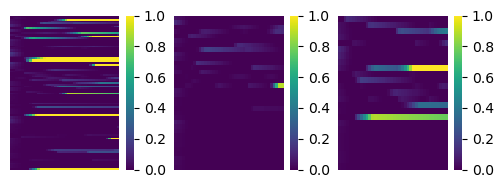

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot(data, ax, vmin=0, vmax=1):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    sns.heatmap(data2, ax=ax, cmap='viridis', xticklabels=False, yticklabels=False, vmin=vmin, vmax=vmax)
plt.close()

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

# Check if subplots are correctly created
process_and_plot(dict_All_ActivityCa_SPDLS1_Baseline[nr], axes[0])
process_and_plot(dict_All_ActivityCa_SPDLPFC_Baseline[nr], axes[1])
process_and_plot(dict_All_ActivityCa_SPDLS1PFC_Baseline[nr], axes[2])

plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_{nr}_heatmap_Spdl_Catraces.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()


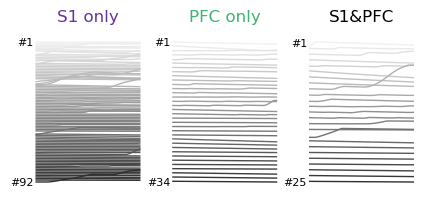

In [134]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(5, 2))  # Increased figure size for better readability

#cmap = sns.light_palette("#008B8B", as_cmap=True)
cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax, title, xlabel=None, title_color='black', cmap=cmap):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    num_lines = data2.shape[0]
    colors = cmap(np.linspace(0., .8, num_lines))
    ax.text(-1,0, f'#1', color='black', ha='right', va='center', fontsize=8) 
    # Plot each line with a label
    for i in range(num_lines):
        line_data = data2[i] - i * 1.5
        ax.plot(0, min(line_data), line_data, color=colors[i], linewidth=1)
    ax.text(-1, min(line_data), f'#{i+1}', color='black', ha='right', va='center', fontsize=8) 
    ax.set_title(title, fontsize=12, color=title_color, pad=10)  # Added padding for the title
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=2, fontsize=10)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr][::] *2  # [::2] Taking every other row
plot_lines(data, axes[0], 'S1 only', title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*2
plot_lines(data, axes[1], 'PFC only', title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*2
plot_lines(data, axes[2], 'S1&PFC')

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_line_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


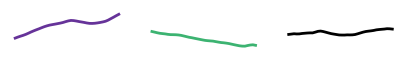

In [116]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(5, .5))  # Increased figure size for better readability

#cmap = sns.light_palette("#008B8B", as_cmap=True)
cmap = sns.light_palette("black", as_cmap=True)

def plot_lines(data, ax,title_color='black', cmap=cmap):
    baseline_columns = data[:, :data.shape[1] // 4]
    mean_baseline = baseline_columns.mean(axis=1)[:, np.newaxis]
    data2 = data - mean_baseline
    ax.plot(np.nanmean(data2, axis=0), color=title_color, linewidth=2)
    ax.set_ylim(-.6, 1)    
    ax.axis('off')  # Hide axis lines and labels

data = dict_All_ActivityCa_SPDLS1_Baseline[nr]*4 # [::2] Taking every other row
plot_lines(data, axes[0],  title_color='rebeccapurple')
data = dict_All_ActivityCa_SPDLPFC_Baseline[nr]*4
plot_lines(data, axes[1], title_color='mediumseagreen')
data = dict_All_ActivityCa_SPDLS1PFC_Baseline[nr]*4
plot_lines(data, axes[2])

output_path = f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_AVG_{nr}_Spdl_CatracesLag.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


In [102]:
#Nr='L1'
Nr='L2&3'

if Nr=='L1':
    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-09-04_07_59_35_AH_wRealTS/L1_Spdl_Global.xlsx"
    dfa=pd.read_excel(path)

    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-09-03_11_00_49_AB_wRealTS/Baseline/All/L1_VigSt_nAUC.xlsx"
    dfi=pd.read_excel(path)
else:
    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_Osc_2024-09-04_07_59_35_AH_wRealTS/L2&3_Spdl_Global.xlsx"
    dfa=pd.read_excel(path)

    path="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/AB_GlobalAnalysis/AVG_VigSt_2024-09-03_11_00_49_AB_wRealTS/Baseline/All/L2&3_VigSt_nAUC.xlsx"
    dfi=pd.read_excel(path)


dfii = dfi.pivot_table(index='Unit_ID', values='NREM', fill_value=0)
dfii2 = dfi.pivot_table(index='Unit_ID', values='RatioNREM_REM', fill_value=0)
dfAll=pd.concat([dfii,dfii2], axis=1, ignore_index=False)


dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 
dfd['NormAUCBeforeS1']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringS1']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringS1', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)



dfd = dfa[dfa['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 
dfd['NormAUCBeforePFC']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforePFC', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringPFC']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringPFC', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 
dfd['NormAUCBeforeGBL']=dfd['AUC_calciumBefore']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCBeforeGBL', aggfunc='mean', fill_value=0)
dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfd['NormAUCDuringGBL']=dfd['AUC_calciumDuring']/(dfd['SpdlDuration']/1000)
dff = dfd.pivot_table(index='Unit_ID', values='NormAUCDuringGBL', aggfunc='mean', fill_value=0)

dfAll=pd.concat([dfAll,dff], axis=1, ignore_index=False)

dfAll['S1diff']=dfAll['NormAUCDuringS1']-dfAll['NormAUCBeforeS1']
dfAll['PFCdiff']=dfAll['NormAUCDuringPFC']-dfAll['NormAUCBeforePFC']
dfAll['GBLdiff']=dfAll['NormAUCDuringGBL']-dfAll['NormAUCBeforeGBL']

dfAll = dfAll.dropna(subset=['RatioNREM_REM'])

df_cleaned=dfAll.copy()
df_cleaned = df_cleaned.dropna(subset=['S1diff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('ACTIVE')

print('S1')
print(sum(dfAllnrem['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['S1diff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['S1diff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['PFCdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('PFC')
print(sum(dfAllnrem['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['PFCdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['PFCdiff']>0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['GBLdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('GBL')
print(sum(dfAllnrem['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllns['GBLdiff']>0)/len(df_cleaned)*100)
print(sum(dfAllrem['GBLdiff']>0)/len(df_cleaned)*100)

if Nr=='L1':
    dfAll.to_excel(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/L1_Act_Spdl.xlsx')
else:
    dfAll.to_excel(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/L2&3_Act_Spdl.xlsx')


print('INACTIVE')

print('S1')
print(sum(dfAllnrem['S1diff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['S1diff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['S1diff']<0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['PFCdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('PFC')
print(sum(dfAllnrem['PFCdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['PFCdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['PFCdiff']<0)/len(df_cleaned)*100)

df_cleaned=dfAll.copy()
df_cleaned = dfAll.dropna(subset=['GBLdiff'])
dfAllnrem=df_cleaned[df_cleaned['RatioNREM_REM']>0.5]
dfAllrem=df_cleaned[df_cleaned['RatioNREM_REM']<-0.5]
dfAllns=df_cleaned[df_cleaned['RatioNREM_REM']<=0.5]
dfAllns=dfAllns[dfAllns['RatioNREM_REM']>=-0.5]

print('GBL')
print(sum(dfAllnrem['GBLdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllns['GBLdiff']<0)/len(df_cleaned)*100)
print(sum(dfAllrem['GBLdiff']<0)/len(df_cleaned)*100)


ACTIVE
S1
5.793450881612091
20.65491183879093
22.921914357682617
PFC
5.289672544080604
8.816120906801007
14.609571788413097
GBL
5.128205128205128
11.282051282051283
16.923076923076923
INACTIVE
S1
11.025641025641026
15.384615384615385
22.82051282051282
PFC
11.586901763224182
27.70780856423174
30.478589420654913
GBL
11.794871794871794
24.615384615384617
27.94871794871795


In [100]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Global'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')
print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()


KeyError: 'session'

In [22]:
dff[dff['%During']>10]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
BlackLinesOK8,2,2,3,9,16,12.50,18.75,12.50,43.75
BlueLinesOK12,0,0,2,4,6,0.00,33.33,0.00,33.33
BlueLinesOK14,1,0,1,7,9,0.00,11.11,11.11,22.22
BlueLinesOK16,0,0,1,8,9,0.00,11.11,0.00,11.11
BlueLinesOK25,0,3,2,2,7,42.86,28.57,0.00,71.43
BlueLinesOK31,1,0,1,5,7,0.00,14.29,14.29,28.57
BlueLinesOK41,0,1,3,2,6,16.67,50.00,0.00,66.67
BlueLinesOK44,0,0,2,4,6,0.00,33.33,0.00,33.33
BlueLinesOK46,1,0,1,4,6,0.00,16.67,16.67,33.33


% Before= 4.43
% During= 4.44
% After= 5.61
% Response= 14.47


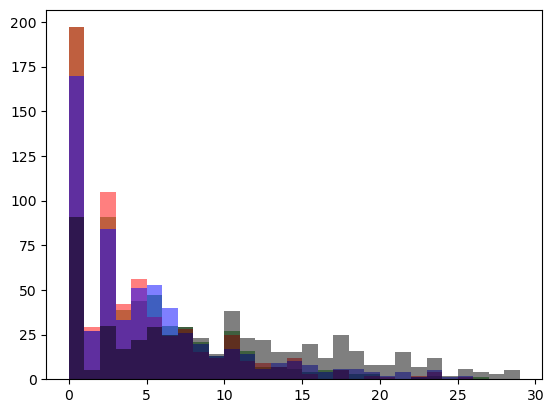

In [104]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'S1'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(0,30,1)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))

plt.show()

In [42]:
dff[dff['%During']>20]

SpikeActivityPreference,After,Before,During,NoPref,Total,%Before,%During,%After,%Response
Unit_ID,,,,,,,,,
Purple511,0,0,1,0,1,0.00,100.00,0.00,100.00
Purple61,16,13,20,36,85,15.29,23.53,18.82,57.65
Purple644,0,0,2,1,3,0.00,66.67,0.00,66.67
ThreeBlueCrossesOK23,3,2,2,2,9,22.22,22.22,33.33,77.78
ThreeColDotsOK112,20,17,20,31,88,19.32,22.73,22.73,64.77
ThreeColDotsOK1346,8,4,11,24,47,8.51,23.40,17.02,48.94
ThreeColDotsOK227,3,3,7,14,27,11.11,25.93,11.11,48.15
ThreeColDotsOK642,7,2,4,4,17,11.76,23.53,41.18,76.47
ThreeColDotsOK683,4,4,4,5,17,23.53,23.53,23.53,70.59


In [ ]:
dfd = dfa[dfa['Drug'] == 'Baseline'] 
dfd = dfd[dfd['GlobalSpindle'] == 'Local'] 
dfd = dfd[dfd['SpdlStartLocation'] == 'PFC'] 

dfd['SpikeActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dfd['CalciumActivityPreference'].replace(np.nan, 'NoPref', inplace=True)
dff = dfd.pivot_table(index='Unit_ID', columns=[dfd['SpikeActivityPreference']], values='SpikeActivityPreference', aggfunc='count', fill_value=0)
dff['Total']=dff.sum(axis=1)

dff['%Before']=np.round(dff['Before']/dff['Total']*100,2)
dff['%During']=np.round(dff['During']/dff['Total']*100,2)
dff['%After']=np.round(dff['After']/dff['Total']*100,2)
dff['%Response']=np.round((dff['Before']+dff['During']+dff['After'])/dff['Total']*100,2)

dff

bin_edges = range(1,100,2)
plt.close()
plt.hist(dff['%Before'], bins=bin_edges,  alpha=0.5, color='green')
plt.hist(dff['%During'], bins=bin_edges,  alpha=0.5, color='red')
plt.hist(dff['%After'], bins=bin_edges,  alpha=0.5, color='blue')
plt.hist(dff['%Response'], bins=bin_edges,  alpha=0.5, color='black')

print('% Before=',round(np.mean(dff['%Before']),2))
print('% During=',round(np.mean(dff['%During']),2))
print('% After=',round(np.mean(dff['%After']),2))
print('% Response=',round(np.mean(dff['%Response']),2))
plt.show()

In [ ]:
dff[dff['%During']>20]